# Overview

Welcome to the world of `braincell`!

This section provides a brief introduction to some of the key concepts and modeling features of the `braincell` framework.

`braincell` is a high-performance computing framework specifically designed for neuron modeling, built on top of [JAX](https://github.com/jax-ml/jax) and [brainstate](https://brainstate.readthedocs.io/). It offers a comprehensive toolchain for neuroscientists, computational neuroscientists, and neuromorphic computing engineers to construct, simulate, and optimize electrophysiologically precise models ranging from ion channels to multi-scale neural networks. The framework integrates advanced features such as modern hardware acceleration and automatic differentiation. The following tutorials will walk you through its layered architecture and core functionalities, helping you quickly understand the design logic behind `braincell`.

In [19]:
import brainunit as u
import brainpy
import braincell
import brainstate
import matplotlib.pyplot as plt

## Hierarchical Architecture

In neuron modeling, models are typically divided into the following major levels based on structural complexity and functional hierarchy:

- `Channel`
- `Ion`
- `Cell`

`braincell` focuses on precise neuronal dynamics modeling at these three levels.
- `Channel`: Ion channels on the membrane, controlling the permeability of specific ions and determining the flow of ionic currents.
- `Ion`: The fundamental charged particles, such as Na⁺, K⁺, and Ca²⁺, that drive changes in membrane potential.
- `Cell`: The basic modeling unit of a single neuron, integrating multiple channels to produce membrane potential dynamics.

Taking the Hodgkin–Huxley (HH) neuron as an example, the relationship among these three levels can be illustrated as follows:

![Hierarchical Structure](../_static/structure-en.png)

From this diagram, it is clear that `Channel`, `Ion`, and `Cell` are tightly interconnected. Biologically, these three levels form the fundamental mechanisms underlying neuronal electrical activity:
- A neuron `Cell` is surrounded by a cell membrane populated with various ion `Channel`s.
- Ion `Channel`s regulate the flow of different `Ion`s across the membrane.
- The movement of `Ion`s changes the potential difference across the membrane, thereby driving neuronal electrical activity.

Together, these levels provide a complete modeling pathway from microscopic mechanisms to macroscopic dynamics of neurons.

## Core Features

The main features of `braincell` include:
- Ion channel modeling: Support for constructing electrophysiologically precise ion channel models using modular components.
- Ion modeling: Support for modular construction of ion dynamics models.
- Neuron modeling: Support for single-compartment and multi-compartment neuron models based on the HH framework.
- Differential equation solvers: High-performance solvers built on [JAX](https://github.com/jax-ml/jax).

In the following sections, we will explore how to use and optimize these features, helping you build models ranging from complete neurons down to fine-grained ion mechanisms, and fully leverage the modeling capabilities of `braincell`.

## Single-Compartment Neuron Modeling

We now turn to how `braincell` can be used to construct neuron models.

Below is an example of building an HH neuron using `braincell`:

In [20]:
class HH(braincell.SingleCompartment):
    def __init__(self, in_size):
        super().__init__(in_size, C=Cm, solver='ind_exp_euler')

        self.na = braincell.ion.SodiumFixed(in_size, E=50. * u.mV)
        self.na.add(
            INa=braincell.channel.INa_TM1991(in_size, g_max=(100. * u.mS * u.cm **-2) * area, V_sh=-63. * u.mV)
        )

        self.k = braincell.ion.PotassiumFixed(in_size, E=-90 * u.mV)
        self.k.add(
            IK=braincell.channel.IK_TM1991(in_size, g_max=(30. * u.mS * u.cm** -2) * area, V_sh=-63. * u.mV)
        )

        self.IL = braincell.channel.IL(
            in_size,
            E=-60. * u.mV,
            g_max=(5. * u.nS * u.cm **-2) * area
        )

We construct the `HH` neuron model by inheriting from `SingleCompartment`, which represents a single-compartment neuron.
`SingleCompartment` itself is the base class for all single-compartment neurons and is derived from `HHTypedNeuron`.
Through `HHTypedNeuron`, both single-compartment neurons (`SingleCompartment`) and multi-compartment neurons (`MultiCompartment`) can be modeled.

`SingleCompartment` provides built-in interfaces for membrane potential while supporting the integration of multiple `Channel`s.
For example, `INa_TM1991`, `IK_TM1991`, and `IL` are concrete subclasses of the `Channel` class.
Taking `INa_TM1991` as an example, it inherits from the sodium channel base class `SodiumChannel`, and thus provides the relevant interfaces.

From this example, we can see that modeling a neuron with `braincell` requires only the composition of the relevant classes at the three levels: `Cell`, `Channel`, and `Ion`.
The inheritance relationships within these three levels are deliberately kept simple in `braincell`.

The neuron `Cell` regulates the flow of different `Ion`s, and each `Ion` is controlled by its corresponding `Channel`.
In the `HH` neuron model above:
- The neuron includes sodium ions (implemented as `SodiumFixed`) and potassium ions (implemented as `PotassiumFixed`).
- Sodium ions determine the behavior of the sodium channel `INa_TM1991`.
- Potassium ions determine the behavior of the potassium channel `IK_TM1991`.
- In addition, `IL` represents a leakage channel, which is not associated with any ion.

This design makes neuron model construction both flexible and modular, facilitating extension and modification.

## Neural Network Modeling

Building upon single-neuron modeling in `braincell`, we can further construct neural network models, seamlessly integrating with the network modeling capabilities of [BrainState](https://brainstate.readthedocs.io/).

Returning to our example, we can use the constructed HH neuron model to build networks for practical applications, such as an excitatory–inhibitory (E–I) network:


In [21]:
V_th = -20. * u.mV
area = 20000 * u.um ** 2
area = area.in_unit(u.cm ** 2)
Cm = (1 * u.uF * u.cm ** -2) * area  # Membrane Capacitance [pF]

class EINet(brainstate.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_exc = 3200
        self.n_inh = 800
        self.num = self.n_exc + self.n_inh
        self.N = HH(self.num)

        self.E = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_exc, self.num, conn_num=0.02, conn_weight=6. * u.nS),
            syn=brainpy.state.Expon(self.num, tau=5. * u.ms),
            out=brainpy.state.COBA(E=0. * u.mV),
            post=self.N
        )
        self.I = brainpy.state.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(self.n_inh, self.num, conn_num=0.02, conn_weight=67. * u.nS),
            syn=brainpy.state.Expon(self.num, tau=10. * u.ms),
            out=brainpy.state.COBA(E=-80. * u.mV),
            post=self.N
        )

    def update(self, t):
        with brainstate.environ.context(t=t):
            spk = self.N.spike.value
            self.E(spk[:self.n_exc])
            self.I(spk[self.n_exc:])
            spk = self.N(0. * u.nA)
            return spk

In [22]:
# network
net = EINet()
_ = brainstate.nn.init_all_states(net)

D:\Document\PyCharm\Project\braincell(collaborator)\.venv\Lib\site-packages\braintools\surrogate.py:72: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  z = jnp.asarray(x >= 0, dtype=x.dtype)


In [23]:
# simulation
with brainstate.environ.context(dt=0.1 * u.ms):
    times = u.math.arange(0. * u.ms, 100. * u.ms, brainstate.environ.get_dt())
    spikes = brainstate.transform.for_loop(net.update, times, pbar=brainstate.transform.ProgressBar(10))

Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:00<00:00, 9927.91it/s]


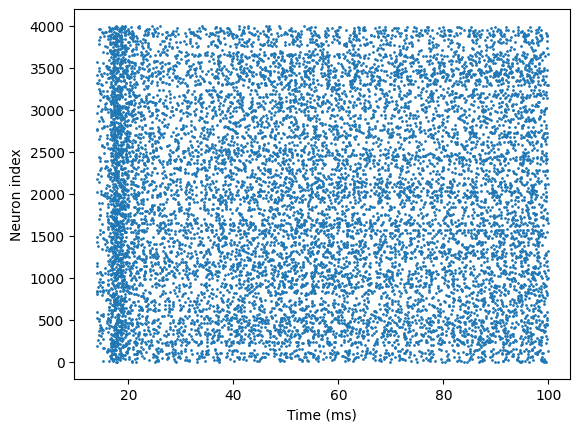

In [24]:
# visualization
t_indices, n_indices = u.math.where(spikes)
plt.scatter(times[t_indices], n_indices, s=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()

In this way, we have used `braincell` to model the HH neuron and implemented a complete E–I network!